In [29]:
import numpy as np
import theano
import theano.tensor as T
import scipy.sparse as sp
from theano import sparse
import lasagne
import time
import scipy.stats as stats
from collections import OrderedDict


In [30]:
# Generate a matrix from a multivariate normal distribution with low-rank covariance matrix
KTRUE = 5
K = 20
N = 100
D = 50
#maxit = 2*KTRUE*(N+D-KTRUE)
maxit = N*D

np.random.seed(seed=10)

#c0np = np.random.gamma(1,1)
#gamma0np = np.random.gamma(1,1)
#gammanp = np.random.gamma(1,1)
#rnp = np.random.gamma(gamma0np/KTRUE, c0np, size=(KTRUE))
#w = np.zeros((D,KTRUE))
#for k in range(KTRUE):
#    print(gammanp*rnp[k])
#    print(gammanp)
#    w[:,k] = np.random.gamma(gammanp*rnp[k]+1e-20, gammanp+1e-20, size = (D))
    

#w   = np.random.uniform(low=0.0, high=1.0, size=(D,KTRUE))
#Introduce some complexity into w
w     = np.random.beta(a = 2, b = 5, size = (D,KTRUE))
#maskw = stats.bernoulli.rvs(0.8, size=(D,KTRUE))
#w     = np.multiply(w,maskw)
var = 0.1
covnp = w.dot(w.T)+var*np.eye(D)

Mnp = np.random.multivariate_normal(np.zeros(D), covnp, N).T

In [31]:
random_w_init = np.random.uniform(low=0.01, high=2.0, size=(D,K))
random_r_init = np.random.uniform(low = 0.01, high = 2.0, size = K)

In [32]:
# We use Theano for our model
srng = T.shared_randomstreams.RandomStreams(seed=120)

#Define Theano Variables
Shared = lambda shape,name: theano.shared(value = np.ones(shape,dtype=theano.config.floatX),
                                          name=name,borrow=True) 

In [33]:
# Let Ynp represent our matrix of partial, noisy observations
#p = 0.03
#p      = 2.5*(maxit/20)/(N*D)
p = 1
#Masknp = np.random.binomial(N, p, size=(N,D)).T
Masknp = stats.bernoulli.rvs(p, size=(D,N))
Mask   = T.as_tensor_variable(Masknp)
M      = T.as_tensor_variable(Mnp)
Y      = Mask*M
zeroY  = T.as_tensor_variable(np.zeros((D,N)))
zero2  = T.as_tensor_variable(np.zeros((D,D)))
zero   = T.as_tensor_variable(np.zeros(D))
st     = T.sum(T.neq(Y, zeroY), axis = 0)
s      = st.eval()


In [34]:
p

1

In [35]:
#Define variables 
W      = Shared((D,K), 'W')
W.set_value(random_w_init)
r      = Shared((K), 'r')
r.set_value(random_r_init)
Gamma  = Shared((1), 'Gamma')
Gamma0 = Shared((1), 'Gamma0')
c0     = Shared((1), 'c0')
sigma  = Shared((1), 'sigma')

t      = T.dscalar('t')

#Define random variables for MVNscan component
zY = srng.normal([D])
zK = srng.normal([K])

#For data given seqentially we need a different covariance matrix for each yn
WWT=T.dot(W, W.T)
Cov=Shared((D,D), 'Cov')
Cov=WWT+sigma[0]*T.identity_like(WWT)
#Cov = T.as_tensor_variable(covnp, name= 'Cov')

#Define lists
mParams = [W, r, Gamma, Gamma0, c0, sigma]

#indexlist = Shared([maxit], 'indexlist')
indexlist = theano.shared(value = np.zeros([maxit],dtype=np.int64),
                                          name='indexlist',borrow=True)


In [36]:
#Define Functions for Langevin Step

def logJointScanFn(n, logLikelihood, Y, Cov, s):
    
    idxs          = T.neq(Y[:,n], zero).nonzero()
    y             = Y[:,n][idxs]
    idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    logLikelihood +=(-1/2.0)*T.log(T.nlinalg.Det()(littlecov))-(1/2.0)*T.dot(y.T, T.dot(T.nlinalg.MatrixInverse()(littlecov), y))
    
    return logLikelihood

def LogJ(mParams, Y, Cov, s):

    W, r, Gamma, Gamma0, c0, sigma = mParams
    #LogJt0=time.clock()
    results, updates = theano.scan(fn=logJointScanFn,
                                   sequences = np.arange(N),
                                   outputs_info=[dict(initial= np.float64(0) ,taps=[-1])],
                                   non_sequences=[Y, Cov, s])
    logJoint  = results[-1]
    logJoint2 = ((D*Gamma*T.log(Gamma))[0]*r).sum()-(D*T.gammaln(Gamma[0]*r)).sum()+((Gamma[0]*r-1)*T.log(W)).sum()-(Gamma[0]*W).sum() + (Gamma0*T.log(c0)-K*T.gammaln(Gamma0/K)+(Gamma0/K-1)[0]*(T.log(r)).sum()-(c0[0]*r).sum()-Gamma-Gamma0-c0)[0]
    logJoint  += logJoint2

    return(logJoint)

def LangevinUpdates(t,logJ,mParams):
    grads = theano.grad(logJ, mParams)
    updates=OrderedDict()
    for param, grad in zip(mParams,grads):
        #print("gradient")
        #print(grad.eval())
        step=(np.power((t+1), -1/2.0))*grad
        updates[param]=T.minimum(T.maximum((param+step).astype(theano.config.floatX), 0.00001*T.ones_like(param)), 1*T.ones_like(param))                                          
    return updates

def Projection(mParams):
    updates=OrderedDict()
    for param in zip(mParams):
        updates[param]=T.minimum(T.maximum(param.astype(theano.config.floatX), (1e-10)*T.ones_like(param.astype(theano.config.floatX))), 10*T.ones_like(param.astype(theano.config.floatX)))                                          
    return updates


def Projection2(mParams):
    grads = theano.grad(logJ, mParams)
    updates=OrderedDict()
    for param, grad in zip(mParams,grads):
        #print("gradient")
        #print(grad.eval())
        #step=0.001*(np.power((t+1), -1/2.0))*grad
        updates[param]=T.minimum(T.maximum((param).astype(theano.config.floatX), 0.00001*T.ones_like(param)), 10*T.ones_like(param))                                          
    return updates



In [37]:
Ytrue = Y.eval()

In [38]:
#Stochastic Gradient Descent

counter = 1

logJ = LogJ(mParams,Y,Cov, s)
param_updates=LangevinUpdates(counter, logJ, mParams)
LangevinStep=theano.function(inputs=[], updates=param_updates)
ParamUpdates=lasagne.updates.adadelta(-logJ,mParams)
AdaDeltaStep=theano.function(inputs=[], updates=ParamUpdates)

param_projection = Projection2(mParams)
ProjectionStep = theano.function(inputs=[], updates = param_projection)


def SGD(Y, limit,construct_lj_list, construct_error_list):
    counter = 1
    logJ = LogJ(mParams,Y,Cov, s)
    param_updates=LangevinUpdates(counter,logJ, mParams)
    ParamUpdates=lasagne.updates.adadelta(-logJ,mParams)

    
    #%%time

    ljlist = []
    errorlist = []
    keepUpdating = True
    
    if construct_lj_list==1:
        
        while keepUpdating:
            """
            if counter % 100 ==0:
                
                print('sigma')
                print(sigma.eval())
                print('r')
                print(r.eval())
                print('w')
                print(W[1,1].eval())
            """
            #LangevinStep()
            AdaDeltaStep()
            ProjectionStep()
            keepUpdating = False if counter>limit else True 
            
            # if construct_elbo_list==1, estimate ELBO by Monte Carlo every 20 steps
            if counter%20==0:
                
                ljlist.append(np.mean([logJ.eval() for i in range(40)]))
                R = 10
                
                if construct_error_list:
                    
                    [y_estimate, sigma_u_o_scan, sigma_ob_inv_scan], updates=theano.scan(fn=MVNormalScan_beta02,
                                              sequences=T.arange(N),
                                              outputs_info=None,
                                              non_sequences=[Y, Mask, Cov, W, zY, zK, st])
                    Yest = y_estimate.eval().T
                    errorlist.append(np.linalg.norm(Yest- Ytrue))  
                    
            counter +=1
    else:
        
        while keepUpdating:
            
            #LangevinStep()
            AdaDeltaStep()
            ProjectionStep()
            keepUpdating = False if counter>limit else True 
            counter += 1
            
    print(counter)
    
    return ljlist, errorlist


def SGDfastscan(W, r, Gamma, Gamma0, c0, sigma):
    mParams = [W, r, Gamma, Gamma0, c0, sigma]
    ParamUpdates=lasagne.updates.adadelta(-logJ,mParams)
    AdaDeltaStep()
    ProjectionStep()
    return W, r, Gamma, Gamma0, c0, sigma

In [39]:
#MVNormalScan constructs our estimate of the entire matrix using conditional multivariate normal

def MVNormalScan_beta02(n, Y, Mask, Cov, W, zY, zK, s):
    
    #construct binaryY_unobs a vector of 1s and 0s where the ith coord is a 1 if we haven't seen the ith coord of y_n    
    binaryY_unobs = T.eq(Y[:,n], zero)
    #construct covariance of the observed entries where the rows/columns with nothing have a 1 on diag (so invertible)
    idxs          = T.neq(Y[:,n], zero).nonzero()
    y             = Y[:,n][idxs]
    idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    littlecov_inv = T.nlinalg.MatrixInverse()(littlecov)
    
    #sigma_observed     = T.outer(binaryY[:,n], binaryY[:,n])*Cov+(binaryY_unobs*T.identity_like(Cov))
    sigma_unobs_obs         = (T.outer(binaryY_unobs, T.neq(Y[:,n], zero)))*Cov
    idxs3                   = T.neq(sigma_unobs_obs, zero2).nonzero()
    little_sigma_unobs_obs = sigma_unobs_obs[:,idxs].reshape((D, s[n])) 
    #sigma_observed_inv = T.nlinalg.MatrixInverse()(sigma_observed)
    dummyY             = T.zeros(D)
    
    #draw the mean vector dummyY from N(0, WWT+sigma^2I) using computationally fast trick
    dummy_results, dummy_updates= theano.scan(lambda prior_result, sigma, zY, W, zK: 
                                              T.sqrt(sigma)[0]*zY+T.dot(W,zK) + prior_result,
                                              sequences=None,
                                              outputs_info= T.zeros(D),
                                              non_sequences=[sigma, zY, W, zK],
                                              n_steps=R)
    
    dummyY       = dummy_results[-1]
    dummyY       /= R
    dummyY_obs   = dummyY[idxs]
    dummyY_unobs = binaryY_unobs*dummyY
    y_est        = dummyY_unobs + T.dot(T.dot(little_sigma_unobs_obs, littlecov_inv), (y-dummyY_obs))
    y_est        = (y_est*binaryY_unobs)-(1e6)*Mask[:,n]
    #y_est        = y_est*binaryY_unobs + Y[:,n]*Mask[:,n]
    
    return [y_est, sigma_unobs_obs, littlecov_inv]



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


602


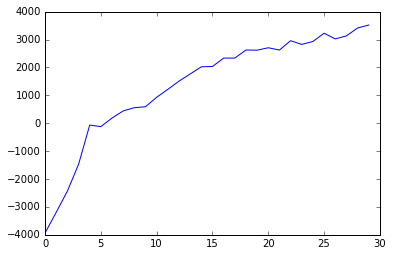

In [40]:
#This serves to test how well, given whatever percent of data observed you set through variable "p", 
#we can estimate the covariance matrix
% pylab inline
import numpy as np
import matplotlib.pyplot as plt

R = 10
[ljlist, errlist] = SGD(Y, 600, 1 ,0)


plt.plot(ljlist)

nameW = 'WK' + str(KTRUE) +'.csv'
namer = 'rK' + str(KTRUE) + '.csv'
namecov = 'truecovsdK' + str(KTRUE) + '.csv'
np.savetxt(nameW,  W.eval(), delimiter = ',')
np.savetxt(namer,  r.eval(), delimiter = ',')
np.savetxt(namecov,  w.dot(w.T), delimiter = ',')

In [13]:
def MainBandit(count, indexlist, Mask, Y):
    
    limit = 1000
    R     = 10
    construct_lj_list = 0
    construct_error_list = 0
    
    ljlist = SGD(Y, limit,construct_lj_list, construct_error_list)
    
    [y_estimate, sigma_u_o_scan, sigma_ob_inv_scan], updates=theano.scan(fn=MVNormalScan_beta02,
                                              sequences=T.arange(N),
                                              outputs_info=None,
                                              non_sequences=[Y, Mask, Cov, W, zY, zK, st])

    y_estimate     = y_estimate.T
    [value, index] = T.max_and_argmax(y_estimate, axis=None, keepdims=False)   
    mf             = T.flatten(Mask)
    mf             = T.inc_subtensor(mf[index],1)
    Mask           = mf.reshape((D,N))
    
    indexlist      = T.set_subtensor(indexlist[count], index)
    
      
    return indexlist,Mask

In [14]:
def ind2sub(array_shape, ind):
    #ind[ind < 0] = -1
    #ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = np.floor(ind / array_shape[1])
    cols = ind % array_shape[1]
    return (int(rows), int(cols))

In [15]:
count     = 0
ratings   = []
R         = 5

[indices, Mask_evolve], updates = theano.scan(fn=MainBandit,
                                               sequences = T.arange(maxit),
                                               outputs_info = [indexlist,Mask],
                                               non_sequences = Y)
indexlistnp = indices[-1].eval()

1002


In [16]:
ratings = []
initial_obs = np.multiply([Masknp!=0], Mnp).flatten()
ratings = initial_obs[initial_obs!=0].tolist()
for i in range(np.size(indexlistnp)):
    [r,c] = ind2sub(np.shape(Mnp), int(indexlistnp[i]))
    ratings.append(Mnp[r,c])

In [17]:
reward = np.cumsum(ratings)

In [24]:
#best = Mnp + 0.00001
#best[Masknp] = 1e-6
#best = best.flatten()
#(np.multiply(Mnp, (1e-6)*Masknp)).flatten()
best = Mnp.flatten()
best.sort()
best[:] =  best[::-1]
best = np.cumsum(best)

random_reward = np.zeros(np.size(Mnp.flatten()))
for i in range(10):
    #random = Mnp + 0.00001
    #random[Masknp] = 1e-6
    #random =  random.flatten()
    #random = (np.multiply(Mnp, (1e-6)*Masknp)).flatten()
    random = Mnp.flatten()
    random = np.random.permutation(random)
    random_reward += np.cumsum(random)/10

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


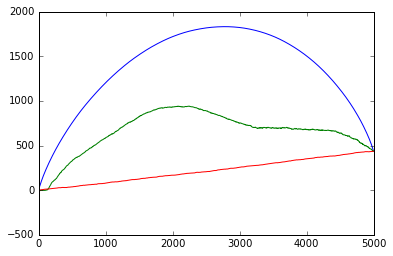

In [25]:
#PLOT ACCUMULATED REWARDS

% pylab inline
import numpy as np
import matplotlib.pyplot as plt

length        = np.minimum(np.size(reward), np.size(best))
reward        = reward[0:length]
best          = best[0:length]
random_reward = random_reward[0:length]

plt.plot(best)
plt.plot(reward)
plt.plot(random_reward)

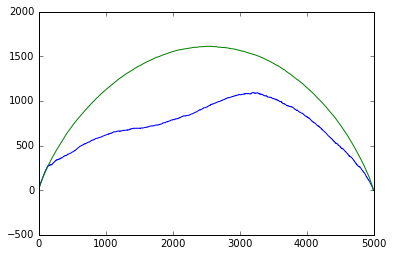

In [26]:
#PLOT REGRET

plt.plot(best-reward)
plt.plot((best-random_reward))

In [ ]:
maxit

In [ ]:
Maskend = Mask_evolve[-1].eval()

In [ ]:
np.sum(Maskend)

In [ ]:
1620/(N*D)

In [28]:
W.eval()

array([[  1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05],
       [  1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05],
       [  1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
          1.00000000e-05,   1.00000000e-05

In [27]:
Cov.eval()

array([[  5.96184544e-01,   2.00000000e-09,   2.00000000e-09, ...,
          2.00000000e-09,   2.00000000e-09,   2.00000000e-09],
       [  2.00000000e-09,   5.96184544e-01,   2.00000000e-09, ...,
          2.00000000e-09,   2.00000000e-09,   2.00000000e-09],
       [  2.00000000e-09,   2.00000000e-09,   5.96184544e-01, ...,
          2.00000000e-09,   2.00000000e-09,   2.00000000e-09],
       ..., 
       [  2.00000000e-09,   2.00000000e-09,   2.00000000e-09, ...,
          5.96184544e-01,   2.00000000e-09,   2.00000000e-09],
       [  2.00000000e-09,   2.00000000e-09,   2.00000000e-09, ...,
          2.00000000e-09,   5.96184544e-01,   2.00000000e-09],
       [  2.00000000e-09,   2.00000000e-09,   2.00000000e-09, ...,
          2.00000000e-09,   2.00000000e-09,   5.96184544e-01]])

In [ ]:
covnp